## Piccard2 Testing Notebook

Google Colab: https://colab.research.google.com/drive/1xjuNG-ebiLlx506hnJM1pvNmSHd3yNmP?usp=sharing

This is a sample notebook that demonstrates usage of the functions in piccard2 using data collected from the cancensus R package.

As you probably know, the piccard package is intended to make it easier to analyze geographically inconsistent census data using a graph data structure. piccard in its current iteration creates the graph network from census data files, and piccard2, which is demonstrated here, applies an existing clustering package (tscluster) to this graph network, which aids analysis and visualizations of the patterns in census data.

In this notebook, we'll go through the clustering process and explore visualizations of the resulting clusters.

First, we'll install all necessary dependencies. piccard and piccard2 will be installed from the new piccard2 git repo, which is necessary to get around some issues in the first iteration of piccard.

In [14]:
# install piccard and piccard2
import os
import subprocess

# Clone the repo (only if not already cloned)
if not os.path.exists("piccard2"):
    subprocess.run(["git", "clone", "https://github.com/ecorbin567/piccard2.git"])

# Change directory
os.chdir("piccard2/src/piccard")

import piccard as pc
import piccard2 as pc2

# install other dependencies, pip install first if needed
from tscluster.tsplot import tsplot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Now we'll use geopandas to read the census data files obtained from cancensus. These files contain necessary information about each census tract in the city of Toronto, as well as three variables for each census tract: number of occupied private dwellings, single-detached houses, and apartments in buildings with five or more storeys.

We rename the columns corresponding to these three variables so that they are treated as the same variable across years.

In [15]:
households_data_2021 = gpd.read_file("https://raw.githubusercontent.com/ecorbin567/piccard2/refs/heads/main/docs/piccard2_testing_data/households_data_2021.geojson")
households_data_2016 = gpd.read_file("https://raw.githubusercontent.com/ecorbin567/piccard2/refs/heads/main/docs/piccard2_testing_data/households_data_2016.geojson")
households_data_2011 = gpd.read_file("https://raw.githubusercontent.com/ecorbin567/piccard2/refs/heads/main/docs/piccard2_testing_data/households_data_2011.geojson")
households_data_2006 = gpd.read_file("https://raw.githubusercontent.com/ecorbin567/piccard2/refs/heads/main/docs/piccard2_testing_data/households_data_2006.geojson")

households_data_2021.rename(columns={'v_CA21_434: Occupied private dwellings by structural type of dwelling data': 'occupied_private_dwellings',
                                     'v_CA21_435: Single-detached house': 'single_detached_house',
                                     'v_CA21_440: Apartment in a building that has five or more storeys': 'apt_five_or_more'}, inplace=True)
households_data_2016.rename(columns={'v_CA16_408: Occupied private dwellings by structural type of dwelling data': 'occupied_private_dwellings',
                                     'v_CA16_409: Single-detached house': 'single_detached_house',
                                     'v_CA16_410: Apartment in a building that has five or more storeys': 'apt_five_or_more'}, inplace=True)
households_data_2011.rename(columns={'v_CA11F_199: Total number of occupied private dwellings by structural type of dwelling': 'occupied_private_dwellings',
                                     'v_CA11F_200: Single-detached house': 'single_detached_house',
                                     'v_CA11F_201: Apartment, building that has five or more storeys': 'apt_five_or_more',}, inplace=True)
households_data_2006.rename(columns={'v_CA06_119: Total number of occupied private dwellings by structural type of dwelling - data': 'occupied_private_dwellings',
                                     'v_CA06_120: Single-detached house': 'single_detached_house',
                                     'v_CA06_124: Apartment, building that has five or more storeys': 'apt_five_or_more',}, inplace=True)

Now we'll create a piccard network table from the data files obtained above. See the piccard documentation for more information about how this is done.

In [16]:
census_dfs = [households_data_2006, households_data_2011, households_data_2016, households_data_2021]
years = ['2006', '2011', '2016', '2021']

network_table = pc.create_network_table(census_dfs, years, 'GeoUID')
network_table

,geouid_2006,geouid_2011,geouid_2016,geouid_2021,shape area_2006,quality flags_2006,type_2006,households_2006,pr_uid_2006,dwellings_2006,...,region name_2021,area (sq km)_2021,occupied_private_dwellings_2021,single_detached_house_2021,apt_five_or_more_2021,name_2021,dwellings 2016_2021,population 2016_2021,households 2016_2021,network_level_2021
0,2006_5350001.00,2011_5350001.00,2016_5350001.00,2021_5350001.00,6.62223,01000,CT,231,35,245,...,0001.00,6.8192,235.0,15.0,0.0,0001.00,274.0,595.0,247.0,4
1,2006_5350002.00,2011_5350002.00,2016_5350002.00,2021_5350002.00,3.26165,00010,CT,262,35,273,...,0002.00,3.3926,285.0,250.0,0.0,0002.00,279.0,620.0,270.0,4
2,2006_5350003.00,2011_5350003.00,2016_5350003.00,2021_5350003.00,0.93043,None,CT,1,35,1,...,0003.00,0.9455,265.0,0.0,265.0,0003.00,267.0,749.0,258.0,4
3,2006_5350004.00,2011_5350004.00,2016_5350004.00,2021_5350004.00,0.34390,02020,CT,3335,35,3614,...,0004.00,0.3404,3275.0,70.0,1790.0,0004.00,3609.0,6686.0,3455.0,4
4,2006_5350005.00,2011_5350005.00,2016_5350005.00,2021_5350005.00,0.37841,01010,CT,2413,35,2575,...,0005.00,0.3764,3720.0,40.0,2420.0,0005.00,3729.0,6424.0,3424.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,2006_5350378.22,2011_5350378.22,2016_5350378.22,2021_5350378.22,0.53116,00000,CT,862,35,880,...,0378.22,0.5321,870.0,800.0,0.0,0378.22,891.0,3454.0,877.0,4
583,2006_5350378.23,2011_5350378.23,2016_5350378.23,2021_5350378.23,1.53841,00001,CT,1282,35,1309,...,0378.23,1.5314,1280.0,635.0,325.0,0378.23,1334.0,4095.0,1302.0,4
584,2006_5350378.24,2011_5350378.24,2016_5350378.24,2021_5350378.24,2.52091,00011,CT,1861,35,1947,...,0378.24,2.5129,2125.0,450.0,820.0,0378.24,2218.0,6109.0,2147.0,4
585,2006_5350802.01,2011_5350802.01,2016_5350802.01,2021_5350802.01,2.22576,00000,CT,1242,35,1269,...,0802.01,2.1742,1305.0,810.0,0.0,0802.01,1290.0,3829.0,1267.0,4


Next, we'll turn this network table into a 3d numpy array of all possible paths and their corresponding features so we can use it for clustering. In addition to creating the numpy array with clustering_prep, we'll also use tscluster's tsplot package to plot the values for each feature across timesteps. These values will be clustered into groups in the next step.

Note that when specifying the list of columns, you need to specify the column for each individual year in the data. This is because of the way the network table renames columns, but don't worry, every feature is treated the same regardless of year.

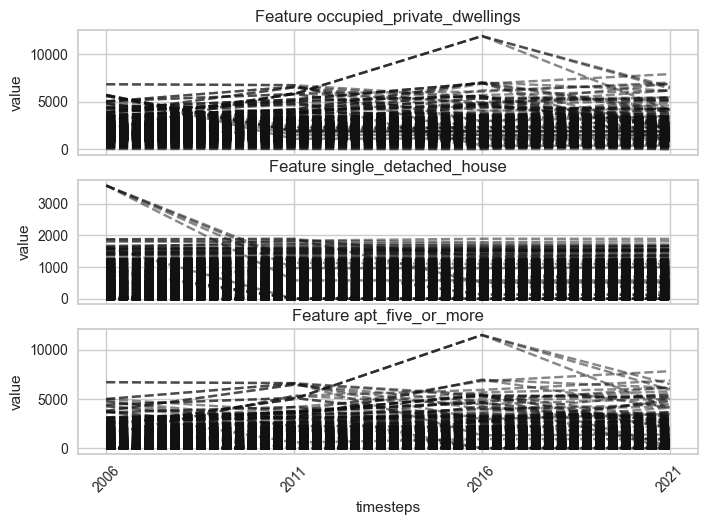

In [17]:
arr, label_dict = pc2.clustering_prep(network_table, 'name', [
    'occupied_private_dwellings_2006', 'single_detached_house_2006', 'apt_five_or_more_2006',
    'occupied_private_dwellings_2011', 'single_detached_house_2011', 'apt_five_or_more_2011',
    'occupied_private_dwellings_2016', 'single_detached_house_2016', 'apt_five_or_more_2016',
    'occupied_private_dwellings_2021', 'single_detached_house_2021', 'apt_five_or_more_2021'])

fig, ax = tsplot.plot(X=arr, label_dict=label_dict)

Before clustering, we will use the elbow function to determine the optimal number of clusters.

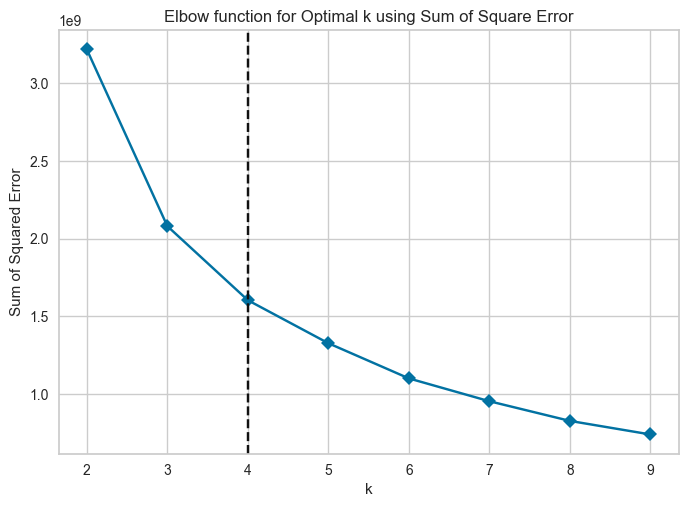

In [18]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

reshaped_arr = arr.reshape(587*4,3)
reshaped_arr = np.nan_to_num(reshaped_arr, nan=-1000000)

model = KMeans(random_state=4,n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10),timings=False, ax=plt.gca())
visualizer.fit(reshaped_arr)       # Fit data to visualizer
plt.title('Elbow function for Optimal k using Sum of Square Error')
plt.xlabel('k')
plt.ylabel('Sum of Squared Error')
plt.show()

There are lots of ways to customize the cluster function, so feel free to try different clustering schemes, algorithms, or even numbers of clusters if the elbow plot is inconclusive.

Before running cluster, we create a piccard graph and pass it into the function.

In [19]:
G = pc.create_network(census_dfs, years, 'GeoUID', 0.05)
tsc = pc2.cluster(network_table, G, 'GeoUID', 4, arr=arr, label_dict=label_dict)

Initialization with kmeans++, Sum of Distance: 2378037516.6667, Max Distance: 6859.2583
Iteration 0, Sum of distance: 1783766278.9400, Max distance: 7594.8886, Number of change: 149
Iteration 5, Sum of distance: 1562560998.9736, Max distance: 7594.8886, Number of change: 46
Iteration 10, Sum of distance: 1553885796.4576, Max distance: 7594.8886, Number of change: 0
Converged at iteration 15, Sum of distance: 1553885796.4576, Max distance: 7594.8886


As you can see below, the network table now contains new columns with each path's cluster assignment at each timestep, and each node in the graph now contains a new feature: each node's cluster assignment.

In [20]:
network_table.head(20)

,geouid_2006,geouid_2011,geouid_2016,geouid_2021,shape area_2006,quality flags_2006,type_2006,households_2006,pr_uid_2006,dwellings_2006,...,apt_five_or_more_2021,name_2021,dwellings 2016_2021,population 2016_2021,households 2016_2021,network_level_2021,cluster_assignment_2006,cluster_assignment_2011,cluster_assignment_2016,cluster_assignment_2021
0,2006_5350001.00,2011_5350001.00,2016_5350001.00,2021_5350001.00,6.62223,01000,CT,231,35,245,...,0.0,0001.00,274.0,595.0,247.0,4,2,2,2,2
1,2006_5350002.00,2011_5350002.00,2016_5350002.00,2021_5350002.00,3.26165,00010,CT,262,35,273,...,0.0,0002.00,279.0,620.0,270.0,4,2,2,2,2
2,2006_5350003.00,2011_5350003.00,2016_5350003.00,2021_5350003.00,0.93043,None,CT,1,35,1,...,265.0,0003.00,267.0,749.0,258.0,4,2,2,2,2
3,2006_5350004.00,2011_5350004.00,2016_5350004.00,2021_5350004.00,0.34390,02020,CT,3335,35,3614,...,1790.0,0004.00,3609.0,6686.0,3455.0,4,1,1,1,1
4,2006_5350005.00,2011_5350005.00,2016_5350005.00,2021_5350005.00,0.37841,01010,CT,2413,35,2575,...,2420.0,0005.00,3729.0,6424.0,3424.0,4,0,1,1,1
5,2006_5350007.01,2011_5350006.00,2016_5350006.00,2021_5350006.00,0.19965,02020,CT,1643,35,1766,...,0.0,0006.00,0.0,0.0,0.0,4,0,2,2,2
6,2006_5350007.01,2011_5350007.01,2016_5350007.01,2021_5350007.01,0.19965,02020,CT,1643,35,1766,...,985.0,0007.01,1827.0,3237.0,1747.0,4,0,0,0,0
7,2006_5350007.02,2011_5350007.02,2016_5350007.02,2021_5350007.02,0.43399,01010,CT,2551,35,2771,...,1820.0,0007.02,2653.0,4753.0,2506.0,4,1,1,1,1
8,2006_5350008.00,2011_5350008.00,2016_5350008.01,2021_5350008.01,2.11154,02020,CT,2103,35,2417,...,5020.0,0008.01,5192.0,7503.0,4954.0,4,0,3,3,3
9,2006_5350008.00,2011_5350008.00,2016_5350008.02,2021_5350008.02,2.11154,02020,CT,2103,35,2417,...,6875.0,0008.02,6390.0,9942.0,6060.0,4,0,3,3,3


In [21]:
list(G.nodes(data=True))[:3]

[('2006_5350001.00',
  {'Shape Area': 6.62223,
   'Quality Flags': '01000',
   'Type': 'CT',
   'Households': 231,
   'PR_UID': '35',
   'Dwellings': 245,
   'Population': 571,
   'CMA_UID': '35535',
   'CSD_UID': '3520005',
   'CD_UID': '3520',
   'Region Name': 'Toronto',
   'Area (sq km)': 6.62223,
   'occupied_private_dwellings': 230.0,
   'single_detached_house': 10.0,
   'apt_five_or_more': 0.0,
   'NHS Non-Return Rate': nan,
   'Adjusted Population (previous Census)': nan,
   'name': nan,
   'Dwellings 2016': nan,
   'Population 2016': nan,
   'Households 2016': nan,
   'network_level': 1,
   'cluster_assignment': 2}),
 ('2011_5350001.00',
  {'Shape Area': 6.62211,
   'Quality Flags': '00000',
   'Type': 'CT',
   'Households': 264,
   'PR_UID': '35',
   'Dwellings': 283,
   'Population': 604,
   'CMA_UID': '35535',
   'CSD_UID': '3520005',
   'CD_UID': '3520',
   'Region Name': 'Toronto',
   'Area (sq km)': 6.62211,
   'occupied_private_dwellings': 265.0,
   'single_detached_hou

Finally, we'll use piccard2's plot_clusters function, inspired by tsplot, to visualize the cluster assignments. This visualization is not intended for interpreting the results of the clustering or its real-world meaning, but rather for evaluating how well the clustering algorithm performed and what changes might need to be made for a better fit.

Similarly to the cluster function, plot_clusters is very customizable, so feel free to try out visualizing different groups of clusters together!

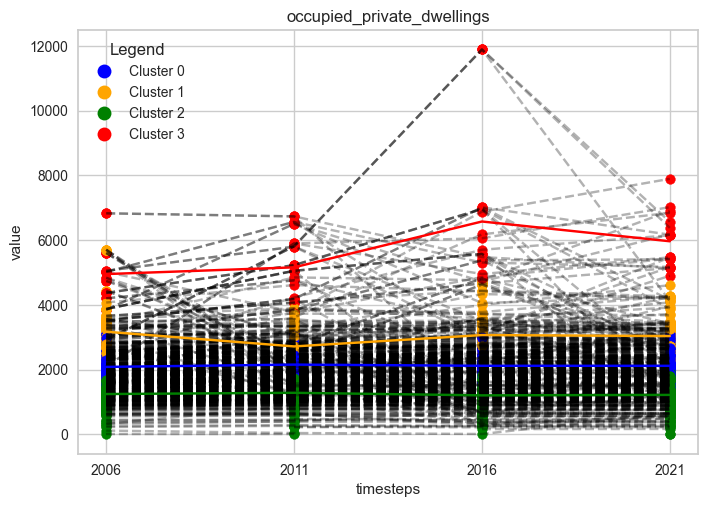

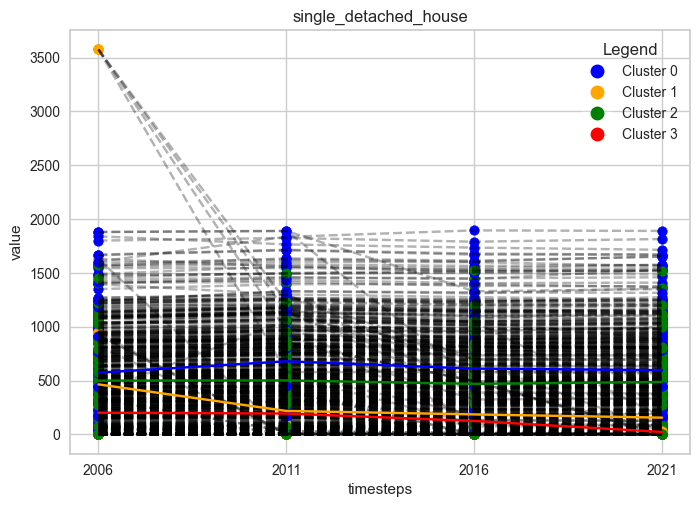

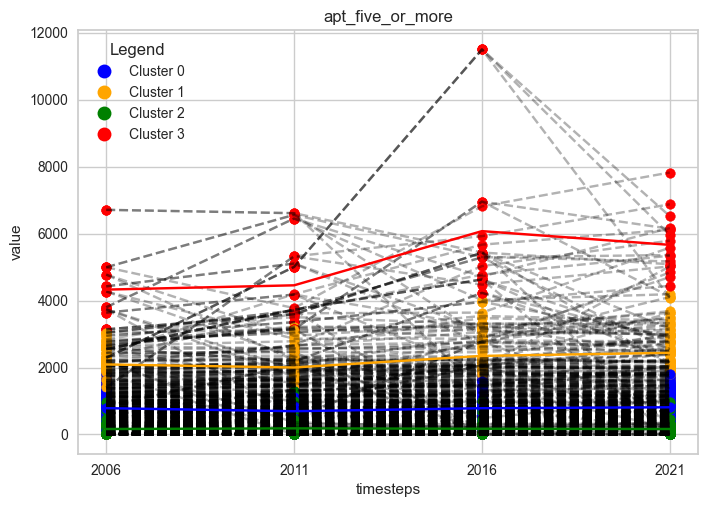

In [22]:
pc2.plot_clusters(network_table, tsc)

Now it's time to start interpreting the cluster assignments! parallel_plot shows a Sankey diagram of each path's cluster assignments over time.

In [23]:
figure = pc2.parallel_plot(network_table,'cluster_assignment', years,height=600)
figure.show()

AttributeError: module 'piccard2' has no attribute 'parallel_plot'

cluster_count_plot shows just the number of paths assigned to each cluster over time, but it provides a helpful colour-coding of clusters to differentiate them.

In [ ]:
pc2.cluster_count_plot(network_table, 'cluster_assignment', years, x_label='Year', y_label='Number of Census Tracts', figure_size=(10,5), stacked=True)

Finally, clustered_map_plot shows a map of cluster assignments at their real geographic locations at each timestep. 

There are two ways to run this function; you could run the helper function join_geometries yourself and pass in the result (this is recommended if you are using a column id different than the default GeoUID), or you could pass in the network table and geographical data file and have join_geometries run for you.

First method: running join_geometries yourself.

In [ ]:
for year in years:
    network_table[f'cluster_assignment_{year}'] = network_table[f'cluster_assignment_{year}'].astype(str)

# Plot for each year
for year in ['2006', '2011', '2016', '2021']:
    gdf = pc2.join_geometries(f"piccard2_testing_data/households_data_{year}.geojson",network_table, year,"GeoUID","geouid")
    pc2.clustered_map_plot(year, cluster_col_prefix="cluster_assignment", gdf=gdf)

Second method: passing in network table and geographical data file. We used geojson but this works for any file readable by geopandas.

In [ ]:
for year in ['2006', '2011', '2016', '2021']:
    pc2.clustered_map_plot(
        year=year,
        cluster_col_prefix='cluster_assignment',
        geojson_path=f"piccard2_testing_data/households_data_{year}.geojson",
        network_table=network_table
    )